In [2]:
!pip install pandas numpy matplotlib -q

In [3]:
import pandas as pd
import numpy as np

In [4]:
df_data = pd.read_csv('data.csv',encoding='latin-1')

In [5]:
df_AP = pd.read_csv('AP.csv')

In [6]:
df_endpoints = pd.read_csv('endpoints.csv', header=None)
df_endpoints.rename(columns={0:'Address',2:"Packets",3:"Bytes",6:"Tx Packets",7:"Tx Bytes",8:"Rx Packets",9:"Rx Bytes"},inplace=True)
df_endpoints.drop([1,4,5], axis=1, inplace=True)

In [7]:
print(
    "Num. of Mac Addresses:", len(df_endpoints["Address"].unique()) - df_endpoints["Address"].isna().sum()
)

Num. of Mac Addresses: 12792


In [8]:
print("No. of Unique Access points: ",len(df_AP['BSSID'].unique()))

No. of Unique Access points:  142


In [9]:
unique_addresses = df_endpoints["Address"].unique()
unique_bssids = df_AP['BSSID'].unique()
clients = [address for address in unique_addresses if address not in unique_bssids]
num_unique_clients = len(clients)
print("No. of Unique Clients: ", num_unique_clients)

No. of Unique Clients:  12757


In [10]:
clients_signal_data = {}

source_addresses = df_data["Source address"].tolist()
signal_strengths = df_data["Signal strength (dBm)"].tolist()
data_rates = df_data["Data rate (Mb/s)"].tolist()

for source_address, signal_strength, data_rate in zip(source_addresses, signal_strengths, data_rates):
    if pd.notna(source_address) and pd.notna(signal_strength) and source_address in clients:
        if source_address not in clients_signal_data:
            clients_signal_data[source_address] = {
                "count": 0,
                "signal": 0,
                "bitrate": 0,
            }
        clients_signal_data[source_address]["signal"] += float(signal_strength.split()[0])
        clients_signal_data[source_address]["count"] += 1
        clients_signal_data[source_address]["bitrate"] += float(data_rate)

In [11]:
for client in clients_signal_data:
    clients_signal_data[client]["signal"] /= clients_signal_data[client]["count"]
    clients_signal_data[client]["bitrate"] /= clients_signal_data[client]["count"]
client = pd.DataFrame.from_dict(clients_signal_data, orient='index')
client = client.sort_values(by=['count'],ascending=True)
column_rename_mapping = {
    "count": "Occurrences",
    "signal": "Average Signal Strength (dBm)",
    "bitrate": "Average Bit Rate (Mbps)",
}
client.rename(columns=column_rename_mapping, inplace=True)
client["Mac Address"] = client.index
client.index = range(len(client))
client.to_csv("client_data.csv",index=False)

In [12]:
standards = {}

for standard in df_data["PHY type"].str.split().str[0].dropna():
    if standard not in standards:
        standards[standard] = 0
    standards[standard] += 1

In [13]:
print(standards)

{'802.11g': 203018, '802.11b': 5373, '802.11n': 18320}


In [14]:
i = 0
throughputs = {}

length_values = df_data["Length"].tolist()
time_values = df_data["Time"].astype(float).tolist()

for length, time in zip(length_values, time_values):
    if pd.notna(length):
        if time >= i and time < i + 2:
            if i not in throughputs:
                throughputs[i] = 0
            throughputs[i] += length
        else:
            i += 2
            if i not in throughputs:
                throughputs[i] = 0
            throughputs[i] += length

for i in throughputs:
    throughputs[i] /= 2
    throughputs[i] *= 8

Text(0, 0.5, 'Throughput')

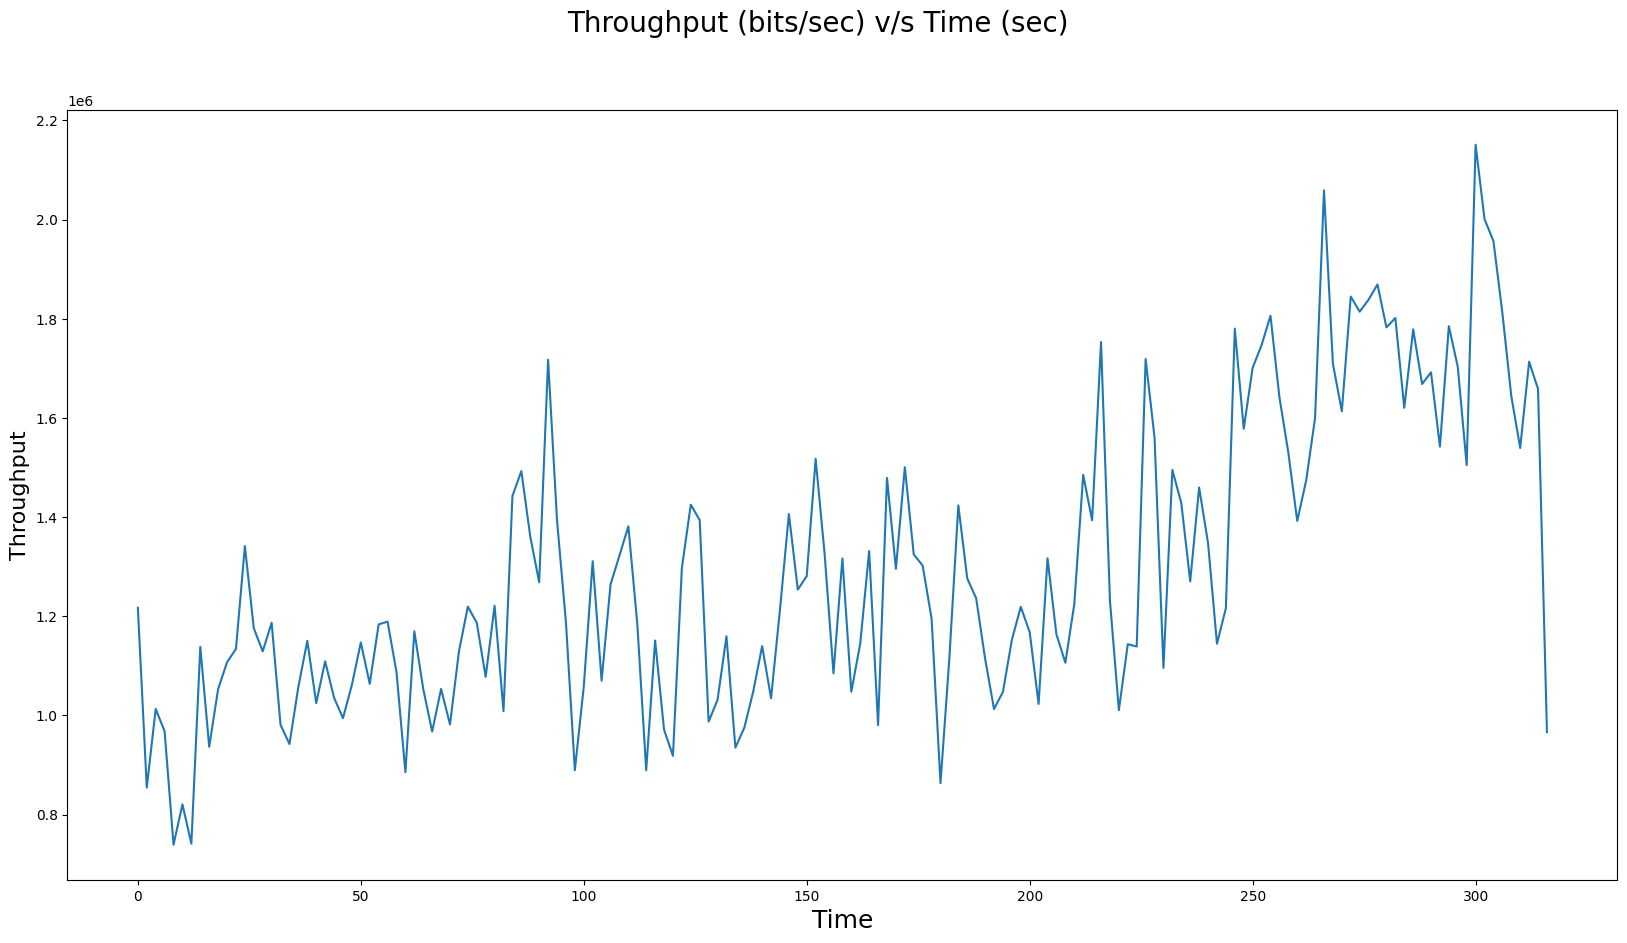

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
plt.plot(throughputs.keys(),throughputs.values())
fig.suptitle('Throughput (bits/sec) v/s Time (sec)', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Throughput', fontsize=16)